In [177]:
import numpy as np 
import pandas as pd 
import pyreadstat
import matplotlib.pyplot as plt

In [178]:
# reading the metro file
fp3 = "./metro cities/3_LASI_W1_Individual_metrocities_28-03-22.sav"
df_fp3, meta_fp3 = pyreadstat.read_sav(fp3, encoding="latin1")

In [179]:
# Function to get the variable name given a column label (case-insensitive)
def get_varname_by_label(meta, target_label):
    target_label = target_label.strip().lower()
    for var, label in meta.column_names_to_labels.items():
        if label is not None and label.strip().lower() == target_label:
            return var
    return None

# Define a function to recode yes/no responses (assuming 1=Yes, 2=No)
def recode_yes(x):
    return 1 if x == 1 else 0  # Convert 1 to 1, everything else to 0

In [180]:
df_fp3['metrocity'].unique()

array([1., 3., 2., 4.])

In [181]:
get_varname_by_label(meta_fp3,"Place of residence")

'residence'

##### Definition 2:
Hard threshold: Individuals who have lived in their current city for more than 20 years will not be considered migrants (Binary Variable).

##### Definition 3:
Duration-based categories: Migration status classified into ordinal categories such as <2 years, <5 years, <10 years in the current location. (Ordinal Variable).

Create migration_3 with ordinal groups:
1. 0-2 years -> 1
2. 3-5 years -> 2
3. 6-10 years -> 3
4. 11-20 years -> 4
5. 21-40 years -> 5
6. .>40 years -> 6
7. NaN values -> 0


In [182]:
# params for definition 2
THRESHOLD = 20

# params for definition 3
BINS = [-np.inf, 2, 5, 10, 20, 40, np.inf]
LABELS = [1, 2, 3, 4, 5, 6]

# params for outcome - mental health (CIDI SF score method)
# Define the column names directly (based on the lowercase version of LASI dataset codes)
cols_cidi1 = ["mh204", "mh205", "mh206", "mh207", "mh208", "mh209", "mh210", "mh211"]
cols_cidi2 = ["mh217", "mh218", "mh219", "mh220", "mh221", "mh222"]

# Screening questions
col_MH201 = "mh201"  # Screening for dysphoria
col_MH214 = "mh214"  # Screening for anhedonia

CIDI_1_THRESHOLD = 3 # Depression: if CIDI_1 score >=3, then 1 else 0

In [183]:
# Get variable name for "Since how many years living continuously in this area"
col_name_years = get_varname_by_label(meta_fp3, "Since how many years living continuously in this area")
if col_name_years is None:
    raise ValueError("Column label 'Since how many years living continuously in this area' not found in fp3.sav metadata.")

# Convert the column to numeric (handling errors)
years_living = pd.to_numeric(df_fp3[col_name_years], errors='coerce')

# Create a new DataFrame for migration_2 and migration_3
df_input = pd.DataFrame()


# Defining migration_1

In [184]:

# Retrieve variable names for place of birth
col_birth_country = get_varname_by_label(meta_fp3, "Place of birth-country")
col_birth_state   = get_varname_by_label(meta_fp3, "Place of birth-state")
col_birth_district = get_varname_by_label(meta_fp3, "Place of birth-district")
col_birth_village  = get_varname_by_label(meta_fp3, "Place of birth-village/town")

# Retrieve variable names for childhood residence
col_child_country = get_varname_by_label(meta_fp3, "Lived most of your childhood-Country")
col_child_district = get_varname_by_label(meta_fp3, "Lived most of your childhood-distirct")
col_child_state   = get_varname_by_label(meta_fp3, "Lived most of your childhood-state")
col_child_village  = get_varname_by_label(meta_fp3, "Lived most of your childhood-village/town")

# Retrieve variable names for adult residence
col_adult_country = get_varname_by_label(meta_fp3, "Lived most of your adult life-country")
col_adult_state   = get_varname_by_label(meta_fp3, "Lived most of your adult life-state")
col_adult_district = get_varname_by_label(meta_fp3, "Lived most of your adult life-district")
col_adult_village  = get_varname_by_label(meta_fp3, "Lived most of your adult life-village/town")


col_current_state = 'state'


# Check that all required variables were found
for name, col in [("Place of birth-country", col_birth_country),
                  ("Place of birth-state", col_birth_state),
                  ("Place of birth-district", col_birth_district),
                  ("Place of birth-village/town", col_birth_village),
                  ("Lived most of your childhood-Country", col_child_country),
                  ("Lived most of your childhood-distirct", col_child_district),
                  ("Lived most of your childhood-state", col_child_state),
                  ("Lived most of your childhood-village/town", col_child_village),
                  ("Lived most of your adult life-country", col_adult_country),
                  ("Lived most of your adult life-state", col_adult_state),
                  ("Lived most of your adult life-district", col_adult_district),
                  ("Lived most of your adult life-village/town", col_adult_village)]:
    if col is None:
        raise ValueError(f"Column label '{name}' not found in fp3.sav metadata.")

# Extract the relevant columns and clean the data
def clean_series(series):
    return series.astype(str).str.strip().str.lower().fillna("")

birth_country = clean_series(df_fp3[col_birth_country])
birth_state = clean_series(df_fp3[col_birth_state])
birth_district = clean_series(df_fp3[col_birth_district])
birth_village = clean_series(df_fp3[col_birth_village])

child_country = clean_series(df_fp3[col_child_country])
child_state = clean_series(df_fp3[col_child_state])
child_district = clean_series(df_fp3[col_child_district])
child_village = clean_series(df_fp3[col_child_village])

adult_country = clean_series(df_fp3[col_adult_country])
adult_state = clean_series(df_fp3[col_adult_state])
adult_district = clean_series(df_fp3[col_adult_district])
adult_village = clean_series(df_fp3[col_adult_village])



current_state=clean_series(df_fp3[col_current_state])
mapping={'tamil nadu': 'chennai', 'west bengal': 'kolkata', 'maharahstra': 'mumbai', 'delhi':'delhi'}
current_city = current_state.map(mapping)

# Create concatenated location strings (using a separator to clearly mark boundaries)
birth_location = birth_country + "|" + birth_state + "|" + birth_district + "|" + birth_village
child_location = child_country + "|" + child_state + "|" + child_district + "|" + child_village
adult_location = adult_country + "|" + adult_state + "|" + adult_district + "|" + adult_village


# Compute migration indicators:
# Childhood Migration Indicator: 1 if any level differs between place of birth and childhood residence, else 0.
child_migration = (birth_location != child_location).astype(int)

# Adult Migration Indicator: 1 if any level differs between place of birth and adult residence, else 0.
# adult_migration = (birth_location != adult_location).astype(int) # original
# adult_migration = (adult_district != current_city).astype(int) # updated
adult_migration = (((2017-df_fp3['dm004_year'])-14-(df_fp3['dm016']))>20).astype(int)

# Create a new DataFrame with the concatenated locations and migration indicators
df_life_course_migration = pd.DataFrame({
    "Birth Location": birth_location,
    "Childhood Location": child_location,
    "Childhood Migration Indicator": child_migration,
    "Adult Location": adult_location,
    "Adult Migration Indicator": adult_migration
})

df_input["migration_1"] = np.where(
    years_living == 9993,
    "0",
    np.where(child_migration == 1, "child_migration",
             np.where(adult_migration == 1, "adult_migration", "0"))
)


# Display the first few rows of the resulting DataFrame
print(df_input.head())


       migration_1
0  adult_migration
1  adult_migration
2                0
3  adult_migration
4                0


# Defining migration 2 and 3

In [185]:

# Create migration_2: 0 if years >= THRESHOLD, else 1
df_input["migration_2"] = np.where(years_living >= THRESHOLD, 0, 1)

# Use pd.cut, and fill NaN values with a default category (e.g., 0 for unknown)
df_input["migration_3"] = pd.cut(years_living, bins=BINS, labels=LABELS, right=True)

# Convert migration_3 to integer, replacing NaN with 0 (or any default category you prefer)
df_input["migration_3"] = df_input["migration_3"].cat.add_categories(0).fillna(0).astype(int)


# Display first few rows of the new DataFrame
print(df_input.head())


       migration_1  migration_2  migration_3
0  adult_migration            1            3
1  adult_migration            1            4
2                0            1            4
3  adult_migration            0            5
4                0            0            5


# Defining migration 4

In [186]:
# Get variable names by column labels (using your previously defined function)
col_DM017 = get_varname_by_label(meta_fp3, "Place of residence")
col_DM018 = get_varname_by_label(meta_fp3, "Place of last residence-village/town")

# Extract the columns for DM017 and DM018
# (These variables are assumed to contain numeric codes: 1 for village, 2 for town)
place_birth = df_fp3[col_DM017]
place_last_res = df_fp3[col_DM018]

# For clarity, create a new DataFrame with only the two variables:
df_migration_type = pd.DataFrame({
    "Place of Birth": place_birth,
    "Place of Last Residence": place_last_res,
    "state": current_state
})

# Define a function to classify migration type based on rural/urban codes
def classify_migration(row):
    pb = row["Place of Birth"]
    plr = row["Place of Last Residence"]
    # Check for missing values (if not coded as 1 or 2, you might want to handle them separately)
    if pd.isna(pb) or pd.isna(plr):
        return "0"
    if plr==1:
        return "Rural-to-Urban"
    elif plr==2:
        return "Urban-to-Urban"
    
    
    # if pb == 1 and plr == 1:
    #     return "Rural-to-Rural"
    # elif pb == 1 and plr == 2:
    #     return "Rural-to-Urban"
    # elif pb == 2 and plr == 1:
    #     return "Urban-to-Rural"
    # elif pb == 2 and plr == 2:
    #     return "Urban-to-Urban"
    # else:
    #     return np.nan

# Apply the function to each row to create a new column 'Migration Type'
df_input["migration_4"] = df_migration_type.apply(classify_migration, axis=1)
df_input.loc[df_input["migration_2"]==0,"migration_4"] = "0"
# Optionally, display the first few rows of the resulting DataFrame
print(df_input.head())


       migration_1  migration_2  migration_3     migration_4
0  adult_migration            1            3  Urban-to-Urban
1  adult_migration            1            4  Rural-to-Urban
2                0            1            4  Rural-to-Urban
3  adult_migration            0            5               0
4                0            0            5               0


In [187]:
df_input["migration_4"].value_counts(), df_input["migration_2"].value_counts()

(migration_4
 0                 3798
 Rural-to-Urban     343
 Urban-to-Urban     332
 Name: count, dtype: int64,
 migration_2
 0    3792
 1     681
 Name: count, dtype: int64)

# Defining depression

In [188]:
# Compute CIDI_1 (dysphoria score)
df_fp3["MH201_binary"] = df_fp3[col_MH201].apply(recode_yes)
df_input["CIDI_1"] = df_fp3[cols_cidi1].applymap(recode_yes).sum(axis=1)
df_input.loc[df_fp3["MH201_binary"] == 0, "CIDI_1"] = 0  # Set to 0 if screening was No

# Compute CIDI_2 (anhedonia score)
df_fp3["MH214_binary"] = df_fp3[col_MH214].apply(recode_yes)
df_input["CIDI_2"] = df_fp3[cols_cidi2].applymap(recode_yes).sum(axis=1)
df_input.loc[df_fp3["MH214_binary"] == 0, "CIDI_2"] = 0  # Set to 0 if screening was No

# Create binary depression variable (1 if CIDI_1 >= CIDI_1_THRESHOLD, else 0)
df_input["Depression"] = df_input["CIDI_1"].apply(lambda x: 1 if x >= CIDI_1_THRESHOLD else 0)


C:\Users\siddh\AppData\Local\Temp\ipykernel_19668\1461186384.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_input["CIDI_1"] = df_fp3[cols_cidi1].applymap(recode_yes).sum(axis=1)
C:\Users\siddh\AppData\Local\Temp\ipykernel_19668\1461186384.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_input["CIDI_2"] = df_fp3[cols_cidi2].applymap(recode_yes).sum(axis=1)


In [189]:
print(df_input.head())

       migration_1  migration_2  migration_3     migration_4  CIDI_1  CIDI_2  \
0  adult_migration            1            3  Urban-to-Urban       0       0   
1  adult_migration            1            4  Rural-to-Urban       0       0   
2                0            1            4  Rural-to-Urban       0       0   
3  adult_migration            0            5               0       0       0   
4                0            0            5               0       0       0   

   Depression  
0           0  
1           0  
2           0  
3           0  
4           0  


In [190]:
counts = df_input["migration_1"].value_counts()
print(counts)
print()
counts = df_input["migration_2"].value_counts()
print(counts)
print()
counts = df_input["migration_3"].value_counts()
print(counts)
print()
counts = df_input["migration_4"].value_counts()
print(counts)
print()
counts = df_input["Depression"].value_counts()
print(counts)


migration_1
0                  3572
adult_migration     679
child_migration     222
Name: count, dtype: int64

migration_2
0    3792
1     681
Name: count, dtype: int64

migration_3
6    2182
5    1394
4     542
3     211
2      87
1      51
0       6
Name: count, dtype: int64

migration_4
0                 3798
Rural-to-Urban     343
Urban-to-Urban     332
Name: count, dtype: int64

Depression
0    4321
1     152
Name: count, dtype: int64


In [191]:
# df['dm005'] # age
# df['dm008'] #education level
# df['fs318'] # living arrangements
# df['fs323'] # relationship with family and friends -  leave for now
# df['co101']-df['co107'] # comsumption -- household not individual

# Odds Ratio using migration_2 defn

In [192]:
import pandas as pd

def one_hot_encode(df, column):
    dummies = pd.get_dummies(df[column], prefix=column).astype(int)
    dummies.columns = [f"{column}_{i+1}" for i in range(dummies.shape[1])]

    for col in dummies.columns:
        df[col] = dummies[col]


In [193]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [194]:
df_fp3['migration_2']=df_input['migration_2']

In [195]:
binary_features=['migration_2']
numerical_features=['dm005']
ordinal_features=['dm008']
categorial_cols=['fs318']
categorial_features=[]
for col in categorial_cols:
    one_hot_encode(df_fp3,col)

    for i in range(df_fp3[col].nunique()):
        categorial_features.append(col+f'_{i+1}')

feature_cols= binary_features + numerical_features + ordinal_features + categorial_features

In [196]:
X=df_fp3[feature_cols]

for col in categorial_features + ordinal_features+ binary_features:
    X.loc[:, col] = X[col].fillna(X[col].mode()[0])
for col in numerical_features:
    X.loc[:, col] = X[col].fillna(X[col].mean())

X=sm.add_constant(X)
X.dropna(inplace=True)

In [197]:
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [198]:
print(vif_data)

      Variable        VIF
0        const  35.928449
1  migration_2   1.026981
2        dm005   1.200894
3        dm008   1.012105
4      fs318_1   1.018061
5      fs318_2   1.090463
6      fs318_3   1.141120
7      fs318_4   1.002560


In [199]:
# Fit logistic regression model
y = df_input['Depression']
model = sm.Logit(y, X).fit()

# Display model summary
print("Adjusted odds ratio: ",np.exp(model.params[1]))
odds_migration=np.sum((df_input['migration_2']==1) & (df_input['Depression']==1))/np.sum((df_input['migration_2']==1) & (df_input['Depression']==0))
odds_not_migration=np.sum((df_input['migration_2']==0) & (df_input['Depression']==1))/np.sum((df_input['migration_2']==0) & (df_input['Depression']==0))
print("Unadjusted odds ratio: ", odds_migration/odds_not_migration)

         Current function value: 0.147179
         Iterations: 35
Adjusted odds ratio:  1.1503841246442899
Unadjusted odds ratio:  1.045662100456621


c:\Users\siddh\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\siddh\AppData\Local\Temp\ipykernel_19668\1169611995.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Adjusted odds ratio: ",np.exp(model.params[1]))


In [200]:
df_fp3['migration_1']=df_input['migration_1']
df_fp3['migration_2']=df_input['migration_2']
df_fp3['migration_3']=df_input['migration_3']
df_fp3['migration_4']=df_input['migration_4']
df_fp3['Depression']=df_input['Depression']


In [201]:
df_fp3['migration_3']

0       3
1       4
2       4
3       5
4       5
       ..
4468    6
4469    6
4470    6
4471    6
4472    6
Name: migration_3, Length: 4473, dtype: int32

# Percentages

### Migration_1

In [202]:
num_migrated=np.sum(df_fp3['migration_1']!='0')
total=len(df_fp3)
adult_migrated=np.sum(df_fp3['migration_1']=='adult_migration')
child_migrated=np.sum(df_fp3['migration_1']=='child_migration')
adult_migrated_and_depressed=np.sum((df_fp3['migration_1']=='adult_migration') & (df_fp3['Depression']==1))
child_migrated_and_depressed=np.sum((df_fp3['migration_1']=='child_migration') & (df_fp3['Depression']==1))
print("percentate depressed among those migrated in adulthood: ",adult_migrated_and_depressed/adult_migrated)
print("percentate depressed among those migrated in childhood: ",child_migrated_and_depressed/child_migrated)

percentate depressed among those migrated in adulthood:  0.036818851251840944
percentate depressed among those migrated in childhood:  0.04504504504504504


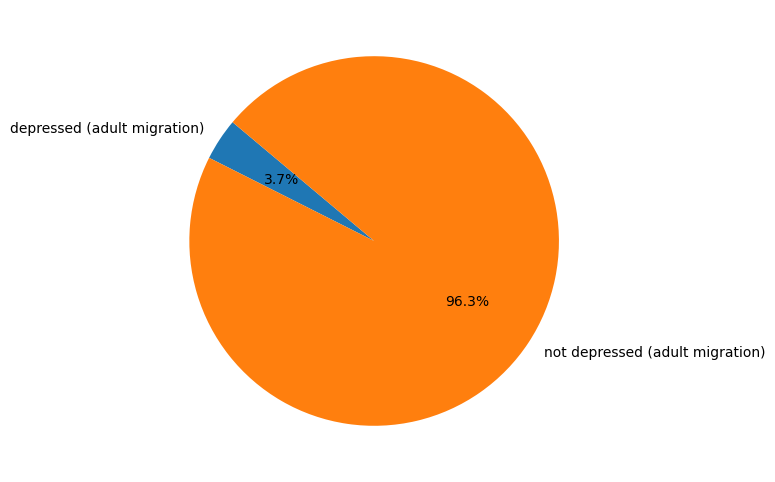

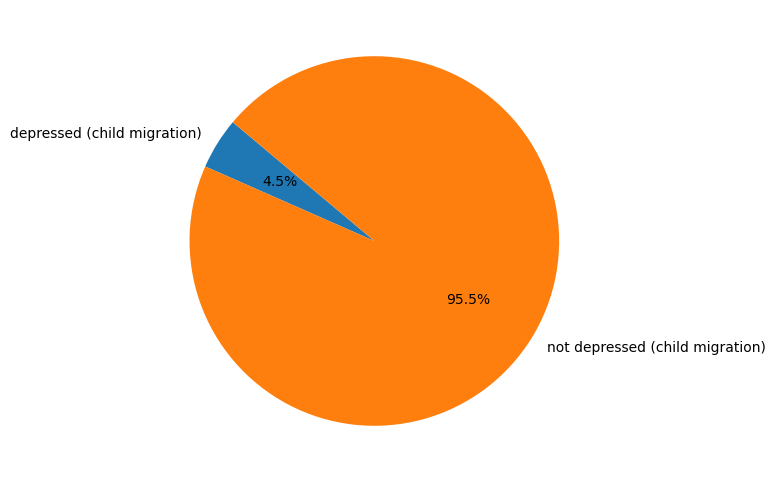

In [203]:

# Data (Fix logical conditions)
labels = ['depressed (adult migration)', 'not depressed (adult migration)']
values = [
    np.sum((df_fp3['migration_1']=='adult_migration') & (df_fp3['Depression']==1)),  # Count cases
    np.sum((df_fp3['migration_1']=='adult_migration') & (df_fp3['Depression']==0)),  # Count cases
]

# Create pie chart
plt.figure(figsize=(6, 6))  # Set figure size
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)

# Show the pie chart
plt.show()



# Data (Fix logical conditions)
labels = ['depressed (child migration)', 'not depressed (child migration)']
values = [
    np.sum((df_fp3['migration_1']=='child_migration') & (df_fp3['Depression']==1)),  # Count cases
    np.sum((df_fp3['migration_1']=='child_migration') & (df_fp3['Depression']==0)),  # Count cases
]

# Create pie chart
plt.figure(figsize=(6, 6))  # Set figure size
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)

# Show the pie chart
plt.show()


### Migration_3

percentage depressed for 1:  0.0196078431372549
percentage depressed for 2:  0.011494252873563218
percentage depressed for 3:  0.023696682464454975
percentage depressed for 4:  0.05719557195571956
percentage depressed for 5:  0.043041606886657105
percentage depressed for 6:  0.024289642529789185


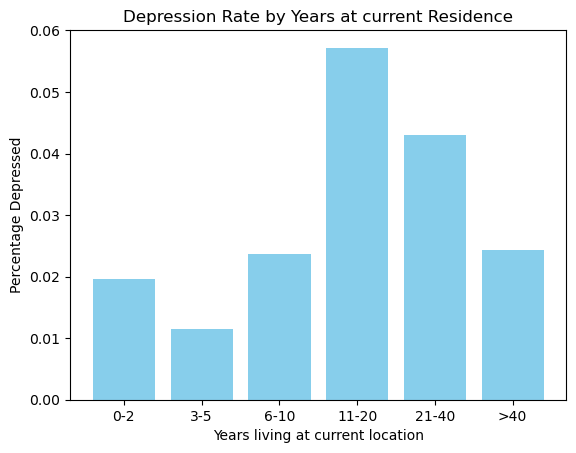

In [215]:
percentages=[]
for i in range(1,7):
    print(f"percentage depressed for {i}: ", (np.sum((df_fp3['migration_3']==i) & (df_fp3['Depression']==1)))  /    np.sum(df_fp3['migration_3']==i))
    
    
    labels = [f'depressed (class {i})', f'not depressed (class {i})']
    values = [
        np.sum((df_fp3['migration_3']==i) & (df_fp3['Depression']==1)),  # Count cases
        np.sum((df_fp3['migration_3']==i) & (df_fp3['Depression']==0)),  # Count cases
    ]

    percentages.append((np.sum((df_fp3['migration_3']==i) & (df_fp3['Depression']==1)))  /    np.sum(df_fp3['migration_3']==i))
    # Create pie chart
    # plt.figure(figsize=(6, 6))  # Set figure size
    # plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)

    # # Show the pie chart
    # plt.show()



labels=[ "0-2",
 "3-5",
 "6-10",
 "11-20",
 "21-40",
 ">40"]

# Create bar chart
plt.bar(labels, percentages, color='skyblue')

# Add labels and title
plt.xlabel("Years living at current location")
plt.ylabel("Percentage Depressed")
plt.title("Depression Rate by Years at current Residence")

# Show the graph
plt.show()


### Migration_4

In [205]:

for x in (df_fp3['migration_4'].unique()):
    print(f"for {x}: ", (np.sum((df_fp3['migration_4']==x) & (df_fp3['Depression']==1)))  /    np.sum(df_fp3['migration_4']==x))

for Urban-to-Urban:  0.04819277108433735
for Rural-to-Urban:  0.023323615160349854
for 0:  0.03370194839389152


In [206]:
np.sum(df_fp3['migration_4']=='Urban-to-Urban'),np.sum(df_fp3['migration_4']=='Rural-to-Urban')

(332, 343)

for Urban-to-Urban:  0.04819277108433735


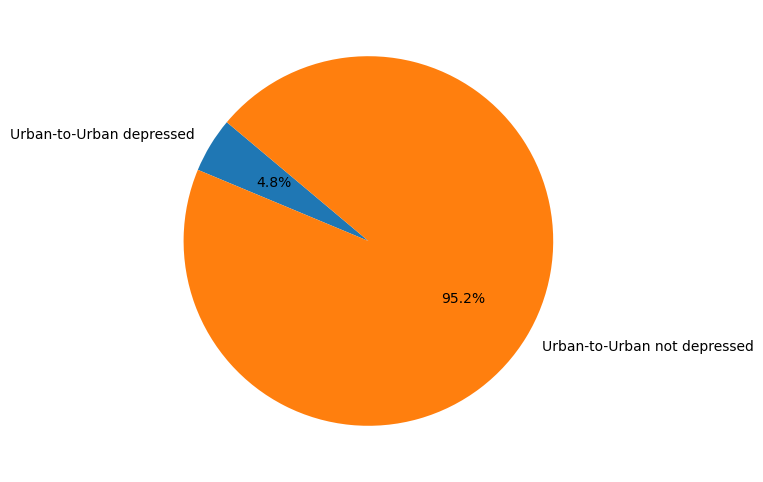

for Rural-to-Urban:  0.023323615160349854


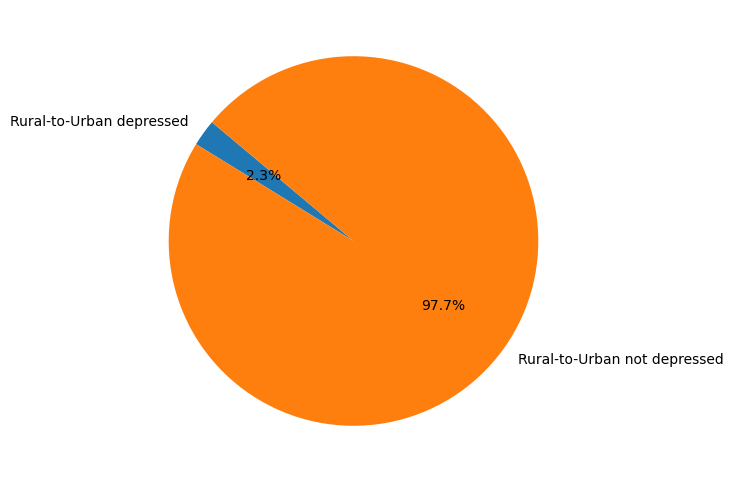

for 0:  0.03370194839389152


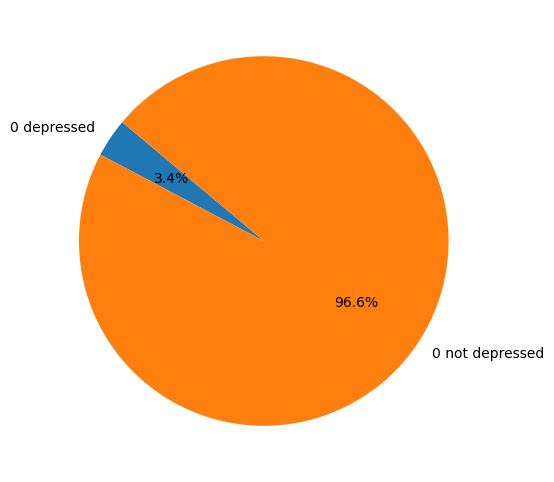

In [207]:

for x in (df_fp3['migration_4'].unique()):
    print(f"for {x}: ", (np.sum((df_fp3['migration_4']==x) & (df_fp3['Depression']==1)))  /    np.sum(df_fp3['migration_4']==x))

    labels = [f'{x} depressed', f'{x} not depressed']
    values = [
        np.sum((df_fp3['migration_4']==x) & (df_fp3['Depression']==1)),  # Count cases
        np.sum((df_fp3['migration_4']==x) & (df_fp3['Depression']==0))  # Count cases
    ]

    # Create pie chart
    plt.figure(figsize=(6, 6))  # Set figure size
    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)

    # Show the pie chart
    plt.show()



In [ ]:
def odds_ratio_for_